In [2]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from selectinf.Simulation.spline import cubic_spline, b_spline
from selectinf.Simulation.H1.nonlinear_H1_helpers import *
from selectinf.RealDataHelpers.rdhelpers import *
from sklearn.decomposition import PCA

In [3]:
fpw = pd.read_csv("fpw.csv", index_col=0)

In [4]:
fpw

,day,dep_delay,distance,plane_age,seats,temp,dewp,humid,wind_dir,wind_speed,wind_gust,precip,pressure,visib,sched_dep_hour,sched_arr_hour
0,1,28.0,187,18.0,20,42.0,30.0,62.18,360.0,9.20624,10.594357,0.00,1017.8,10.00,23.783333,0.983333
1,1,-12.0,1576,21.0,200,42.0,30.0,62.18,360.0,9.20624,10.594357,0.00,1017.8,10.00,23.416667,4.083333
2,1,6.0,1041,18.0,20,41.0,30.0,64.63,250.0,9.20624,10.594357,0.00,1015.7,10.00,8.000000,11.300000
3,1,-7.0,1182,24.0,145,41.0,30.0,64.63,250.0,9.20624,10.594357,0.00,1015.7,10.00,8.033333,10.833333
4,1,-4.0,1029,22.0,145,41.0,30.0,64.63,250.0,9.20624,10.594357,0.00,1015.7,10.00,8.000000,10.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8435,27,-3.0,187,11.0,200,42.0,41.0,96.21,0.0,0.00000,0.000000,0.00,1019.2,1.50,5.500000,6.700000
8436,27,2.0,1089,1.0,185,42.0,41.0,96.21,0.0,0.00000,0.000000,0.00,1019.2,1.50,5.416667,8.650000
8437,16,240.0,1089,7.0,189,26.0,23.0,88.23,330.0,4.60312,5.297178,0.01,1020.9,1.25,5.416667,8.650000
8438,27,-5.0,209,17.0,95,42.0,39.0,89.01,160.0,4.60312,5.297178,0.00,1023.2,10.00,23.000000,0.450000


In [5]:
fpw["precip"].unique()

array([0.    , 0.01  , 0.02  , 0.03  , 0.0001, 0.04  ])

In [6]:
Y = fpw["dep_delay"]
X = fpw.drop(["dep_delay", 'day', "wind_gust"], axis=1)

In [7]:
X.shape

(7358, 13)

# Implementation: Construct splines

In [8]:
def get_splines(x_nl, x_l, nknots, degree, intercept):
    bs = b_spline(data_nl=np.array(x_nl), data_l=np.array(x_l), 
                  nknots=nknots, degree=degree, intercept=intercept)
    bs.construct_splines(use_quantiles=True, equally_spaced=False, center=False)
    design_train = bs.get_spline_data()
    design_train *= np.sqrt(design_train.shape[0])
    design_train[:, 0] = 1
    # Returning group labels with 0 meaning the intercept (if applicable)
    groups = bs.get_groups()

    return design_train, groups


# Implementation: Validate significant interactions on a holdout set

In [9]:
def validate(x_test, design_test, y_test, nonzero, selected_groups, 
             groups = None, n_features=None, intercept=True, mode="allpairs", level=0.9):
    X_E = design_test[:, nonzero]
    active_flag = np.zeros(np.unique(groups).shape[0])
    active_flag[selected_groups] = 1.
    raw_data=np.array(x_test)

    if intercept:
        active_vars_flag = active_flag[1:]
    else:
        active_vars_flag = active_flag

    data_interaction = {}
    task_idx = []
    for i in range(n_features):
        for j in range(i + 1, n_features):
            if mode == "allpairs":
                task_idx.append((i, j))
                data_interaction[(i, j)] = raw_data[:, i] * raw_data[:, j]
            elif mode == 'weakhierarchy':
                if active_vars_flag[i] or active_vars_flag[j]:
                    task_idx.append((i, j))
                    data_interaction[(i, j)] = raw_data[:, i] * raw_data[:, j]
            elif mode == 'stronghierarchy':
                if active_vars_flag[i] and active_vars_flag[j]:
                    task_idx.append((i, j))
                    data_interaction[(i, j)] = raw_data[:, i] * raw_data[:, j]

    result_dict = interaction_t_tests_all(X_E, y_test, n_features,
                                          active_vars_flag, data_interaction,
                                          level=level, mode=mode)

    return result_dict

# Repeated subsampling

In [10]:
def subsampling_inference(Y, X, test_size, n_rep, alpha = 0.1):
    
    f1_dict = {"method":[], "F1":[], "Precision":[], "Recall":[]}
    MSE_dict = {"method":[], "MSE_test":[], "MSE_train":[]}
    main_effects_freq_Naive = {name: 0 for name in X.columns}
    interaction_freq_Naive = {}
    main_effects_freq_MLE = {name: 0 for name in X.columns}
    interaction_freq_MLE = {}
    
    for i in range(n_rep):
        x_train, x_test, y_train, y_test = train_test_split(X, Y, 
                                                            test_size=test_size,
                                                            random_state=i)
    
        linear = list(x_train.columns[x_train.nunique() < 40])
        x_train_nl = x_train.drop(linear, axis=1)
        x_train_l_temp = x_train[linear]
        x_test_nl = x_test.drop(linear, axis=1)
        x_test_l = x_test[linear]
        n_train = x_train_l_temp.shape[0]
        n_test = x_test_l.shape[0]
        
        x_train_l = (x_train_l_temp - x_train_l_temp.mean()) / (x_train_l_temp.std() * np.sqrt(n_train))
        x_test_l = (x_test_l - x_train_l_temp.mean()) / (x_train_l_temp.std() * np.sqrt(n_test))
        design_train, groups_train = (
            get_splines(x_train_nl, x_train_l, nknots=6, degree=2, intercept=True))
        design_test, groups_test = (
            get_splines(x_test_nl, x_test_l, nknots=6, degree=2, intercept=True))

        names_map = {i: None for i in range(X.shape[1])}
        for i in range(len(x_train_nl.columns)):
            names_map[i] = x_train_nl.columns[i]
        for j in range(len(x_train_nl.columns),
                       len(x_train_nl.columns) + len(x_train_l.columns)):
            names_map[j] = x_train_l.columns[j - len(x_train_nl.columns)]
        print(names_map)
    
        const = group_lasso.gaussian
    
    
        result_naive, nonzero_naive, selected_groups_naive, soln_naive \
            = naive_inference_real_data(X=design_train, Y=np.array(y_train),
                                        raw_data=np.array(x_train),
                                        groups=groups_train, const=const,
                                        n_features=x_train.shape[1],
                                        intercept=True, weight_frac=0.5, level=0.9,
                                        mode="weakhierarchy", root_n_scaled=False)
        
        result_MLE, nonzero_MLE, selected_groups_MLE, soln_MLE \
            = MLE_inference_real_data(X=design_train, Y=np.array(y_train),
                                      raw_data=np.array(x_train), groups=groups_train,
                                      n_features=x_train.shape[1],
                                      intercept=True, weight_frac=0.5, level=0.9,
                                      mode="weakhierarchy",
                                      root_n_scaled=False, proportion=0.9)
        
        if result_naive is not None:
            for g in selected_groups_naive:
                if g != 0:
                    main_effects_freq_Naive[names_map[g-1]] += 1
    
            result_naive_validate = validate(x_test, design_test, y_test, nonzero_naive,
                                             selected_groups_naive, groups=groups_train,
                                             n_features=x_train.shape[1],
                                             intercept=True, mode="weakhierarchy", level=0.9)
            naive_df = pd.DataFrame(result_naive)
            naive_test_df = pd.DataFrame(result_naive_validate)
            naive_train = [(naive_df["pval"][k] < alpha) for k in range(naive_df.shape[0])]
            naive_test = [(naive_test_df["pval"][k] < alpha) for k in range(naive_test_df.shape[0])]
            f1_dict["method"].append("Naive")
            f1_dict["F1"].append(f1_score(naive_test, naive_train))
            f1_dict["Precision"].append(precision_score(naive_test, naive_train))
            f1_dict["Recall"].append(recall_score(naive_test, naive_train))
            
            for index, row in naive_df.iterrows():
                if row["pval"] < alpha:
                    i = row["i"]
                    j = row["j"]
                    if (names_map[i], names_map[j]) in interaction_freq_Naive.keys():
                        interaction_freq_Naive[(names_map[i], names_map[j])] += 1
                    elif (names_map[j], names_map[i]) in interaction_freq_Naive.keys():
                        interaction_freq_Naive[(names_map[j], names_map[i])] += 1
                    else:
                        interaction_freq_Naive[(names_map[i], names_map[j])] = 1
            
        else:
            f1_dict["method"].append("Naive")
            f1_dict["F1"].append(0)
            f1_dict["Precision"].append(0)
            f1_dict["Recall"].append(0)
    
        if result_MLE is not None:
            for g in selected_groups_MLE:
                if g != 0:
                    main_effects_freq_MLE[names_map[g-1]] += 1
            result_MLE_validate = validate(x_test, design_test, y_test, nonzero_MLE,
                                           selected_groups_MLE, groups=groups_train,
                                           n_features=x_train.shape[1],
                                           intercept=True, mode="weakhierarchy", level=0.9)
        
            MLE_df = pd.DataFrame(result_MLE)
            MLE_test_df = pd.DataFrame(result_MLE_validate)
            MLE_train = [(MLE_df["pval"][k] < alpha) for k in range(MLE_df.shape[0])]
            MLE_test = [(MLE_test_df["pval"][k] < alpha) for k in range(MLE_test_df.shape[0])]
            f1_dict["method"].append("MLE")
            f1_dict["F1"].append(f1_score(MLE_test, MLE_train))
            f1_dict["Precision"].append(precision_score(MLE_test, MLE_train))
            f1_dict["Recall"].append(recall_score(MLE_test, MLE_train))
            
            for index, row in MLE_df.iterrows():
                if row["pval"] < alpha:
                    i = row["i"]
                    j = row["j"]
                    if (names_map[i], names_map[j]) in interaction_freq_MLE.keys():
                        interaction_freq_MLE[(names_map[i], names_map[j])] += 1
                    elif (names_map[j], names_map[i]) in interaction_freq_MLE.keys():
                        interaction_freq_MLE[(names_map[j], names_map[i])] += 1
                    else:
                        interaction_freq_MLE[(names_map[i], names_map[j])] = 1
        else:
            f1_dict["method"].append("MLE")
            f1_dict["F1"].append(0)
            f1_dict["Precision"].append(0)
            f1_dict["Recall"].append(0)
        
        MSE_naive = np.mean((y_test - predict(soln_naive, design_test))**2)
        MSE_naive_train = np.mean((y_train - predict(soln_naive, design_train))**2)
        MSE_MLE = np.mean((y_test - predict(soln_MLE, design_test))**2)
        MSE_MLE_train = np.mean((y_train - predict(soln_MLE, design_train))**2)
        MSE_dict["method"].append("Naive")
        MSE_dict["MSE_test"].append(MSE_naive)
        MSE_dict["MSE_train"].append(MSE_naive_train)
        MSE_dict["method"].append("MLE")
        MSE_dict["MSE_test"].append(MSE_MLE)
        MSE_dict["MSE_train"].append(MSE_MLE_train)
        
    return (f1_dict, MSE_dict, interaction_freq_Naive, interaction_freq_MLE,
            main_effects_freq_Naive, main_effects_freq_MLE)
    

In [53]:
(f1_dict, MSE_dict, interaction_freq_Naive, interaction_freq_MLE,
            main_effects_freq_Naive, main_effects_freq_MLE)\
    = subsampling_inference(Y, X, test_size=0.9, n_rep=100, alpha=0.1)

Equally spaced quantile knots used.
Equally spaced quantile knots used.
{0: 'distance', 1: 'temp', 2: 'dewp', 3: 'humid', 4: 'pressure', 5: 'plane_age', 6: 'seats', 7: 'wind_dir', 8: 'wind_speed', 9: 'precip', 10: 'visib', 11: 'sched_dep_hour', 12: 'sched_arr_hour'}
Selected groups: [0, 2, 3, 5, 6, 8, 9, 11, 12]
Naive Selected Groups: 9
Selected groups: [0, 3, 5, 6, 8, 9, 11, 12]
MLE Selected Groups: 8
Equally spaced quantile knots used.
Equally spaced quantile knots used.
{0: 'distance', 1: 'temp', 2: 'dewp', 3: 'humid', 4: 'pressure', 5: 'plane_age', 6: 'seats', 7: 'wind_dir', 8: 'wind_speed', 9: 'precip', 10: 'visib', 11: 'sched_dep_hour', 12: 'sched_arr_hour'}
Selected groups: [0, 2, 5, 7, 11, 12]
Naive Selected Groups: 6
Selected groups: [0, 1, 2, 5, 7, 11, 12]
MLE Selected Groups: 7
Equally spaced quantile knots used.
Equally spaced quantile knots used.
{0: 'distance', 1: 'temp', 2: 'dewp', 3: 'humid', 4: 'pressure', 5: 'plane_age', 6: 'seats', 7: 'wind_dir', 8: 'wind_speed', 9: 

/Users/yilingh/Desktop/PhD/SI_Codes/SI-Interaction/env3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Equally spaced quantile knots used.
Equally spaced quantile knots used.
{0: 'distance', 1: 'temp', 2: 'dewp', 3: 'humid', 4: 'pressure', 5: 'plane_age', 6: 'seats', 7: 'wind_dir', 8: 'wind_speed', 9: 'precip', 10: 'visib', 11: 'sched_dep_hour', 12: 'sched_arr_hour'}
Selected groups: [0, 1, 2, 5, 9, 11, 12]
Naive Selected Groups: 7
Selected groups: [0, 1, 2, 5, 9, 11, 12]
MLE Selected Groups: 7


/Users/yilingh/Desktop/PhD/SI_Codes/SI-Interaction/env3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Equally spaced quantile knots used.
Equally spaced quantile knots used.
{0: 'distance', 1: 'dewp', 2: 'humid', 3: 'pressure', 4: 'plane_age', 5: 'seats', 6: 'temp', 7: 'wind_dir', 8: 'wind_speed', 9: 'precip', 10: 'visib', 11: 'sched_dep_hour', 12: 'sched_arr_hour'}
Selected groups: [0, 4, 6, 7, 8, 11, 12, 13]
Naive Selected Groups: 8
Selected groups: [0, 2, 4, 6, 7, 8, 11, 12, 13]
MLE Selected Groups: 9
Equally spaced quantile knots used.
Equally spaced quantile knots used.
{0: 'distance', 1: 'temp', 2: 'dewp', 3: 'humid', 4: 'pressure', 5: 'plane_age', 6: 'seats', 7: 'wind_dir', 8: 'wind_speed', 9: 'precip', 10: 'visib', 11: 'sched_dep_hour', 12: 'sched_arr_hour'}
Selected groups: [0, 2, 5, 7, 9, 11, 12]
Naive Selected Groups: 7
Selected groups: [0, 2, 5, 7, 9, 11, 12]
MLE Selected Groups: 7
Equally spaced quantile knots used.
Equally spaced quantile knots used.
{0: 'distance', 1: 'temp', 2: 'dewp', 3: 'humid', 4: 'pressure', 5: 'plane_age', 6: 'seats', 7: 'wind_dir', 8: 'wind_speed'

In [54]:
X.columns

Index(['distance', 'plane_age', 'seats', 'temp', 'dewp', 'humid', 'wind_dir',
       'wind_speed', 'precip', 'pressure', 'visib', 'sched_dep_hour',
       'sched_arr_hour'],
      dtype='object')

In [55]:
f1_dict.keys()

dict_keys(['method', 'F1', 'Precision', 'Recall'])

<Axes: xlabel='method', ylabel='F1'>

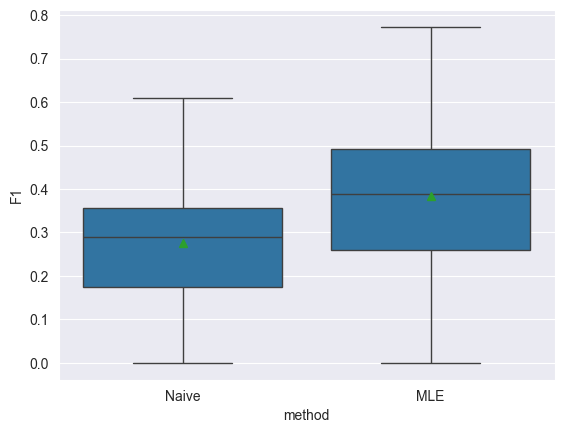

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.boxplot(
    data=pd.DataFrame(f1_dict),
    x='method',
    y='F1',
    showmeans=True
)

<Axes: xlabel='method', ylabel='Precision'>

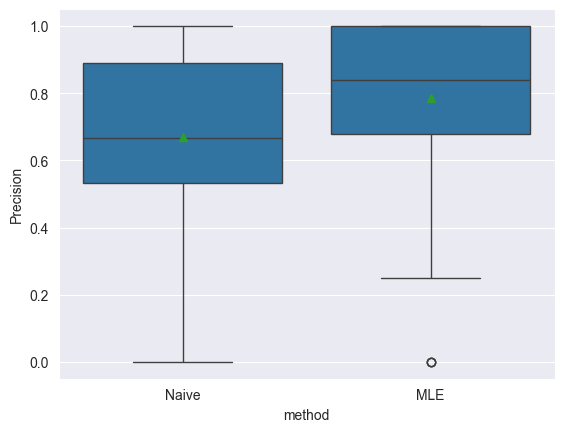

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.boxplot(
    data=pd.DataFrame(f1_dict),
    x='method',
    y='Precision',
    showmeans=True
)

<Axes: xlabel='method', ylabel='Recall'>

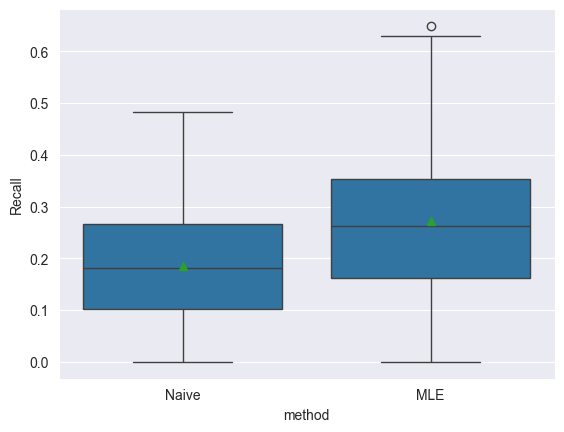

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.boxplot(
    data=pd.DataFrame(f1_dict),
    x='method',
    y='Recall',
    showmeans=True
)

<Axes: xlabel='method', ylabel='MSE_test'>

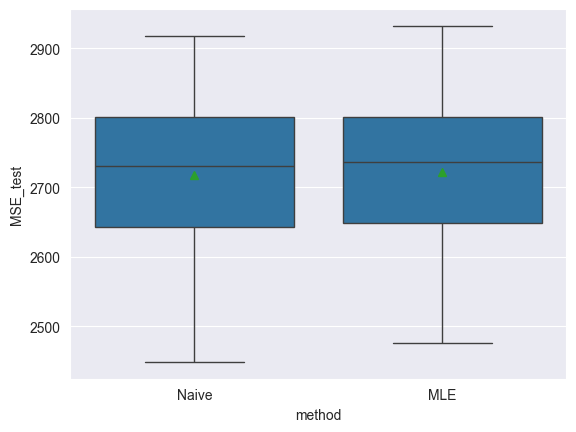

In [59]:
sns.boxplot(
    data=pd.DataFrame(MSE_dict),
    x='method',
    y='MSE_test',
    showmeans=True
)

<Axes: xlabel='method', ylabel='MSE_train'>

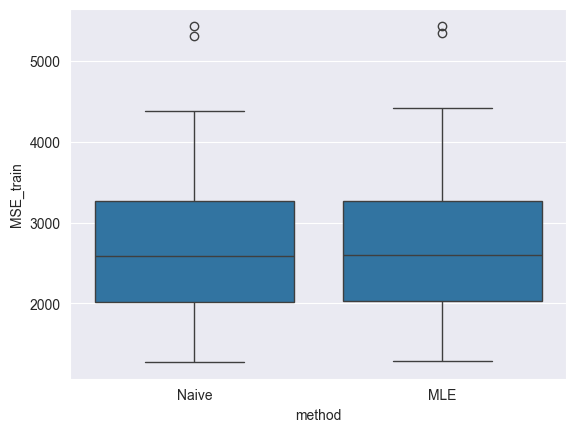

In [60]:
sns.boxplot(
    data=pd.DataFrame(MSE_dict),
    x='method',
    y='MSE_train'
)

In [62]:
interaction_freq_Naive, interaction_freq_MLE

({('distance', 'plane_age'): 3,
  ('distance', 'wind_dir'): 4,
  ('distance', 'sched_dep_hour'): 8,
  ('dewp', 'sched_dep_hour'): 6,
  ('humid', 'wind_dir'): 20,
  ('humid', 'sched_dep_hour'): 34,
  ('pressure', 'seats'): 35,
  ('pressure', 'wind_dir'): 33,
  ('pressure', 'visib'): 39,
  ('pressure', 'sched_dep_hour'): 20,
  ('plane_age', 'visib'): 30,
  ('seats', 'wind_dir'): 44,
  ('precip', 'visib'): 10,
  ('precip', 'sched_dep_hour'): 23,
  ('humid', 'visib'): 48,
  ('visib', 'sched_arr_hour'): 14,
  ('sched_dep_hour', 'sched_arr_hour'): 15,
  ('dewp', 'wind_speed'): 14,
  ('wind_dir', 'sched_dep_hour'): 14,
  ('pressure', 'sched_arr_hour'): 15,
  ('plane_age', 'wind_speed'): 12,
  ('seats', 'sched_dep_hour'): 17,
  ('wind_dir', 'sched_arr_hour'): 16,
  ('wind_speed', 'precip'): 12,
  ('wind_speed', 'sched_arr_hour'): 10,
  ('visib', 'sched_dep_hour'): 18,
  ('dewp', 'visib'): 14,
  ('humid', 'seats'): 24,
  ('humid', 'pressure'): 13,
  ('pressure', 'plane_age'): 13,
  ('pressure',

In [63]:
sorted(interaction_freq_Naive.items(), key=lambda kv: kv[1], reverse=True)

[(('humid', 'visib'), 48),
 (('seats', 'wind_dir'), 44),
 (('pressure', 'visib'), 39),
 (('pressure', 'seats'), 35),
 (('humid', 'sched_dep_hour'), 34),
 (('pressure', 'wind_dir'), 33),
 (('plane_age', 'visib'), 30),
 (('wind_dir', 'visib'), 28),
 (('humid', 'seats'), 24),
 (('precip', 'sched_dep_hour'), 23),
 (('wind_dir', 'wind_speed'), 21),
 (('humid', 'wind_dir'), 20),
 (('pressure', 'sched_dep_hour'), 20),
 (('visib', 'sched_dep_hour'), 18),
 (('seats', 'sched_dep_hour'), 17),
 (('wind_dir', 'sched_arr_hour'), 16),
 (('sched_dep_hour', 'sched_arr_hour'), 15),
 (('pressure', 'sched_arr_hour'), 15),
 (('plane_age', 'wind_dir'), 15),
 (('pressure', 'wind_speed'), 15),
 (('visib', 'sched_arr_hour'), 14),
 (('dewp', 'wind_speed'), 14),
 (('wind_dir', 'sched_dep_hour'), 14),
 (('dewp', 'visib'), 14),
 (('humid', 'pressure'), 13),
 (('pressure', 'plane_age'), 13),
 (('wind_speed', 'sched_dep_hour'), 13),
 (('plane_age', 'wind_speed'), 12),
 (('wind_speed', 'precip'), 12),
 (('seats', 'sc

In [64]:
sorted(interaction_freq_MLE.items(), key=lambda kv: kv[1], reverse=True)

[(('pressure', 'visib'), 56),
 (('humid', 'sched_dep_hour'), 54),
 (('dewp', 'sched_dep_hour'), 43),
 (('visib', 'sched_dep_hour'), 41),
 (('pressure', 'seats'), 40),
 (('seats', 'wind_dir'), 39),
 (('wind_dir', 'visib'), 38),
 (('dewp', 'visib'), 36),
 (('dewp', 'precip'), 35),
 (('wind_speed', 'sched_dep_hour'), 30),
 (('dewp', 'wind_dir'), 29),
 (('dewp', 'pressure'), 29),
 (('pressure', 'wind_dir'), 28),
 (('plane_age', 'visib'), 28),
 (('wind_dir', 'wind_speed'), 26),
 (('humid', 'visib'), 25),
 (('precip', 'visib'), 23),
 (('dewp', 'plane_age'), 22),
 (('pressure', 'wind_speed'), 22),
 (('pressure', 'sched_dep_hour'), 21),
 (('wind_speed', 'precip'), 20),
 (('dewp', 'seats'), 20),
 (('humid', 'wind_dir'), 18),
 (('wind_speed', 'sched_arr_hour'), 18),
 (('pressure', 'plane_age'), 18),
 (('dewp', 'humid'), 18),
 (('plane_age', 'wind_speed'), 17),
 (('plane_age', 'sched_dep_hour'), 16),
 (('temp', 'wind_speed'), 15),
 (('humid', 'wind_speed'), 15),
 (('seats', 'wind_speed'), 15),
 (

In [65]:
sorted(main_effects_freq_Naive.items(), key=lambda kv: kv[1], reverse=True)

[('sched_dep_hour', 97),
 ('pressure', 89),
 ('temp', 87),
 ('visib', 74),
 ('wind_speed', 69),
 ('wind_dir', 64),
 ('seats', 52),
 ('dewp', 38),
 ('sched_arr_hour', 30),
 ('precip', 29),
 ('plane_age', 21),
 ('distance', 9),
 ('humid', 0)]

In [66]:
sorted(main_effects_freq_MLE.items(), key=lambda kv: kv[1], reverse=True)

[('sched_dep_hour', 100),
 ('pressure', 85),
 ('temp', 75),
 ('wind_speed', 67),
 ('wind_dir', 66),
 ('visib', 59),
 ('dewp', 51),
 ('precip', 26),
 ('seats', 22),
 ('sched_arr_hour', 22),
 ('plane_age', 19),
 ('distance', 8),
 ('humid', 0)]

# Focusing on one subsample

In [188]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.9,
                                                    random_state=42)
# Standardize
#x_train = (x_train - x_train.mean()) / x_train.std()
#x_test = (x_test - x_train.mean()) / x_train.std()

In [356]:
linear = list(x_train.columns[x_train.nunique() < 40])

In [357]:
x_train.nunique()

distance           59
plane_age          31
seats              26
temp               41
dewp               52
humid             230
wind_dir           36
wind_speed         21
precip              6
pressure          217
visib              19
sched_dep_hour    206
sched_arr_hour    354
dtype: int64

In [358]:
x_train_nl = x_train.drop(linear, axis=1)
x_train_l_temp = x_train[linear]
x_test_nl = x_test.drop(linear, axis=1)
x_test_l = x_test[linear]
n_train = x_train_l_temp.shape[0]
n_test = x_test_l.shape[0]

x_train_l = (x_train_l_temp - x_train_l_temp.mean()) / (x_train_l_temp.std() * np.sqrt(n_train))
x_test_l = (x_test_l - x_train_l_temp.mean()) / (x_train_l_temp.std() * np.sqrt(n_test))

In [360]:
x_train_nl

,distance,temp,dewp,humid,pressure,sched_dep_hour,sched_arr_hour
6276,2475,37.0,27.0,66.82,1033.0,15.500000,18.933333
7174,2422,40.0,26.0,57.01,1033.1,16.500000,20.000000
1303,2475,37.0,25.0,61.50,1023.1,17.000000,20.533333
6571,1598,35.0,33.0,92.32,1008.2,12.316667,17.083333
5989,301,42.0,31.0,64.75,1012.4,22.983333,0.583333
...,...,...,...,...,...,...,...
5865,213,38.0,33.0,82.00,1026.8,13.983333,15.516667
5921,427,33.0,21.0,60.95,1030.5,9.816667,11.716667
6104,665,37.0,36.0,96.13,1001.9,14.833333,17.350000
909,2586,31.0,23.0,71.89,1009.8,15.833333,19.516667


In [359]:
x_test_l.std()

plane_age     0.012439
seats         0.012695
wind_dir      0.012015
wind_speed    0.012213
precip        0.011678
visib         0.012367
dtype: float64

In [193]:
x_train_l.std()

plane_age     0.036886
seats         0.036886
wind_dir      0.036886
wind_speed    0.036886
precip        0.036886
visib         0.036886
dtype: float64

In [194]:
design_train, groups_train = (
        get_splines(x_train_nl, x_train_l, nknots=6, degree=2, intercept=True))
design_test, groups_test = (
        get_splines(x_test_nl, x_test_l, nknots=6, degree=2, intercept=True))

Equally spaced quantile knots used.
Equally spaced quantile knots used.


In [195]:
# Steps:
# 1. Transform training fully for naive and MLE
# 2. Transform 90% of training for data splitting's selection
# 3. Use 10% of remaining to get the transformed PCs for data splitting's inference
# 4. 

In [196]:
design_train

array([[ 1.        , -1.29469158, -0.51859089, ..., -0.02321697,
         1.70640133,  0.49814698],
       [ 1.        , -1.19756794, -0.48768174, ..., -0.61164706,
        -0.34237836,  0.49814698],
       [ 1.        , -1.29469158, -0.51859089, ..., -1.20007715,
        -0.3630731 ,  0.49814698],
       ...,
       [ 1.        , -0.12116343,  1.10133351, ...,  0.17292639,
         1.70640133, -1.32841514],
       [ 1.        , -1.51037039, -0.5800947 , ...,  0.17292639,
        -0.34237836, -0.23247787],
       [ 1.        , -0.22672314,  1.29537708, ..., -0.02321697,
        -0.3630731 ,  0.49814698]])

In [197]:
design_train.T @ design_train

array([[ 7.35000000e+02, -3.67100058e+02,  4.59106234e+02,
        -4.33438163e+02, -7.45968241e+01, -4.59180683e+02,
        -1.26910180e+02, -5.45186805e+02, -2.82949388e+02,
        -3.33743647e+02,  1.22029202e+02, -4.95963482e+02,
        -3.24920458e+01, -3.74107200e+02,  1.71374326e+02,
        -4.39648318e-14,  8.88178420e-16,  7.46069873e-14,
         2.30926389e-14,  7.99360578e-15,  3.55271368e-15],
       [-3.67100058e+02,  7.35000000e+02,  2.04281037e-14,
         2.80018211e+02,  2.37180387e+01,  2.73259862e+02,
         7.53470033e+01,  2.84940969e+02,  1.49968697e+02,
         1.55389995e+02, -6.42800149e+01,  2.40917848e+02,
         2.43800493e+01,  1.91671590e+02, -5.31155140e+01,
         1.61092469e+01, -2.55856216e+02, -9.41992913e+00,
         1.66531060e+01, -1.37017392e+01,  1.08940864e+01],
       [ 4.59106234e+02,  2.04281037e-14,  7.35000000e+02,
        -2.48589798e+02, -7.28982263e+01, -2.58679981e+02,
        -1.07045308e+02, -3.22637687e+02, -1.94284345e

In [198]:
design_train

array([[ 1.        , -1.29469158, -0.51859089, ..., -0.02321697,
         1.70640133,  0.49814698],
       [ 1.        , -1.19756794, -0.48768174, ..., -0.61164706,
        -0.34237836,  0.49814698],
       [ 1.        , -1.29469158, -0.51859089, ..., -1.20007715,
        -0.3630731 ,  0.49814698],
       ...,
       [ 1.        , -0.12116343,  1.10133351, ...,  0.17292639,
         1.70640133, -1.32841514],
       [ 1.        , -1.51037039, -0.5800947 , ...,  0.17292639,
        -0.34237836, -0.23247787],
       [ 1.        , -0.22672314,  1.29537708, ..., -0.02321697,
        -0.3630731 ,  0.49814698]])

In [199]:
design_train.std(axis=0)

array([0.        , 0.86633933, 0.78091738, 0.80761377, 0.99483633,
       0.78083635, 0.98498027, 0.67067564, 0.92293111, 0.89096449,
       0.98612135, 0.73801871, 0.9990224 , 0.86077279, 0.97243782,
       0.9993195 , 0.9993195 , 0.9993195 , 0.9993195 , 0.9993195 ,
       0.9993195 ])

In [200]:
design_test.std(axis=0)

array([0.        , 0.87850686, 0.78465437, 0.79840987, 0.99396775,
       0.77836609, 0.98646269, 0.67557672, 0.92621893, 0.88931565,
       0.98917161, 0.69592871, 0.9994111 , 0.84888042, 0.97292605,
       1.01222734, 1.03310309, 0.97769863, 0.99383786, 0.95030807,
       1.00635762])

In [201]:
const = group_lasso.gaussian
result_naive, nonzero_naive, selected_groups_naive, soln \
    = naive_inference_real_data(X=design_train, Y=np.array(y_train), 
                                raw_data=np.array(x_train), 
                                groups=groups_train, const=const,
                                n_features=x_train.shape[1], 
                                intercept=True, weight_frac=0.5, level=0.9,
                                mode="weakhierarchy", root_n_scaled=False)

Selected groups: [0, 2, 5, 6, 7, 9, 11, 13]
Naive Selected Groups: 8


In [202]:
pd.DataFrame(result_naive)[pd.DataFrame(result_naive)['pval'] < 0.1]

,i,j,CI_l,CI_u,beta_hat,pval
11,1,6,-0.004813,-0.000700,-0.002756,0.027287
12,1,7,-0.119630,-0.024062,-0.071846,0.013275
16,1,11,-0.096608,-0.006443,-0.051526,0.059787
23,2,12,0.001351,0.017346,0.009349,0.054195
36,4,11,-0.128926,-0.020201,-0.074563,0.023886
50,6,12,-0.004974,0.000002,-0.002486,0.099853
53,7,12,-0.287614,-0.007033,-0.147323,0.083714
58,9,10,0.010666,0.404281,0.207473,0.082525
59,9,12,-0.232027,-0.040315,-0.136171,0.019303
62,11,12,-1.757318,-0.544371,-1.150845,0.001776


In [203]:
result_MLE, nonzero_MLE, selected_groups_MLE, soln_MLE\
    = MLE_inference_real_data(X=design_train, Y=np.array(y_train), 
                              raw_data=np.array(x_train), groups=groups_train, 
                              n_features=x_train.shape[1], 
                              intercept=True, weight_frac=0.5, level=0.9, 
                              mode="weakhierarchy", 
                              root_n_scaled=False, proportion=0.9)

Selected groups: [0, 2, 5, 6, 8, 9, 11, 13]
MLE Selected Groups: 8


In [204]:
pd.DataFrame(result_MLE)[pd.DataFrame(result_MLE)['pval'] < 0.1]

,i,j,CI_l,CI_u,beta_hat,pval
7,1,2,0.007807,0.023873,0.015840,0.001182
11,1,6,-0.020166,-0.005309,-0.012738,0.004795
12,1,7,-0.259521,-0.035893,-0.147707,0.029791
22,2,10,0.002295,0.033528,0.017911,0.059217
31,4,6,-0.011866,-0.003237,-0.007552,0.003987
36,4,11,-0.284397,-0.000538,-0.142467,0.098721
38,5,6,-0.004950,-0.001493,-0.003221,0.002177
45,6,7,-0.030070,-0.008752,-0.019411,0.002741
46,6,8,-31.842092,-0.603693,-16.222893,0.087557
47,6,10,-0.036473,-0.007934,-0.022204,0.010484


In [205]:
result_naive_validate = validate(x_test, design_test, y_test, nonzero_naive, 
                                 selected_groups_naive, groups = groups_train, 
                                 n_features=x_train.shape[1],
                                 intercept=True, mode="weakhierarchy", level=0.9)

In [206]:
pd.DataFrame(result_naive_validate)

,i,j,CI_l,CI_u,beta_hat,pval
0,0,1,-0.000073,5.145407e-05,-0.000011,0.775068
1,0,4,-0.000019,8.652867e-05,0.000034,0.289526
2,0,5,-0.000027,1.682326e-05,-0.000005,0.704026
3,0,6,-0.000010,-5.272651e-07,-0.000005,0.068445
4,0,8,-0.011780,3.088742e-01,0.148547,0.127455
...,...,...,...,...,...,...
58,9,10,-0.009610,6.605867e-02,0.028224,0.219732
59,9,12,-0.037986,1.241174e-03,-0.018372,0.123321
60,10,11,-0.133604,1.502106e-02,-0.059292,0.189332
61,10,12,-0.119281,1.041259e-02,-0.054434,0.167301


In [207]:
result_MLE_validate = validate(x_test, design_test, y_test, nonzero_MLE, 
                                 selected_groups_MLE, groups = groups_train, 
                                 n_features=x_train.shape[1],
                                 intercept=True, mode="weakhierarchy", level=0.9)

In [208]:
pd.DataFrame(result_MLE_validate)

,i,j,CI_l,CI_u,beta_hat,pval
0,0,1,-0.000095,0.000094,-8.195860e-07,0.988624
1,0,4,-0.000021,0.000082,3.059197e-05,0.327620
2,0,5,-0.000027,0.000016,-5.558756e-06,0.670297
3,0,7,-0.000075,0.000161,4.278047e-05,0.551774
4,0,8,-0.011500,0.309137,1.488186e-01,0.126740
...,...,...,...,...,...,...
58,9,10,-0.009445,0.066206,2.838057e-02,0.217092
59,9,12,-0.000287,0.000176,-5.551420e-05,0.693814
60,10,11,-0.132724,0.015817,-5.845333e-02,0.195411
61,10,12,-0.039436,0.011700,-1.386768e-02,0.372251


In [209]:
naive_df = pd.DataFrame(result_naive)
naive_significant = \
    [(naive_df["i"][k], naive_df["j"][k]) for k in range(naive_df.shape[0])
     if naive_df["pval"][k] < 0.1]
naive_insig = \
    [(naive_df["i"][k], naive_df["j"][k]) for k in range(naive_df.shape[0])
     if naive_df["pval"][k] >= 0.1]

In [210]:
naive_test_df = pd.DataFrame(result_naive_validate)
naive_test_significant = \
    [(naive_test_df["i"][k], naive_test_df["j"][k]) for k in range(naive_test_df.shape[0])
     if naive_test_df["pval"][k] < 0.1]
naive_test_insig = \
    [(naive_test_df["i"][k], naive_test_df["j"][k]) for k in range(naive_test_df.shape[0])
     if naive_test_df["pval"][k] >= 0.1]

In [211]:
naive_all = [(naive_test_df["i"][k], naive_test_df["j"][k]) 
             for k in range(naive_test_df.shape[0])]

In [212]:
len(set(naive_test_significant).intersection(set(naive_significant))) / len(set(naive_significant))

0.4

In [213]:
len(set(naive_test_insig).intersection(set(naive_insig))) / len(set(naive_test_insig))

0.8064516129032258

In [214]:
MLE_df = pd.DataFrame(result_MLE)
MLE_significant = \
    [(MLE_df["i"][k], MLE_df["j"][k]) for k in range(MLE_df.shape[0])
     if MLE_df["pval"][k] < 0.1]
MLE_insig = \
    [(MLE_df["i"][k], MLE_df["j"][k]) for k in range(MLE_df.shape[0])
     if MLE_df["pval"][k] >= 0.1]

In [215]:
len(MLE_significant)

13

In [216]:
MLE_test_df = pd.DataFrame(result_MLE_validate)
MLE_test_significant = \
    [(MLE_test_df["i"][k], MLE_test_df["j"][k]) for k in range(MLE_test_df.shape[0])
     if MLE_test_df["pval"][k] < 0.1]
MLE_test_insig = \
    [(MLE_test_df["i"][k], MLE_test_df["j"][k]) for k in range(MLE_test_df.shape[0])
     if MLE_test_df["pval"][k] >= 0.1]

In [217]:
MLE_all = [(MLE_test_df["i"][k], MLE_test_df["j"][k]) 
             for k in range(MLE_test_df.shape[0])]

In [218]:
alpha = 0.1
naive_train = [(naive_df["pval"][k] < alpha) for k in range(naive_df.shape[0])]
naive_test = [(naive_test_df["pval"][k] < alpha) for k in range(naive_test_df.shape[0])]

In [219]:
from sklearn.metrics import confusion_matrix
# tn, fp, 
# fn, tp
confusion_matrix(naive_test, naive_train)

array([[25,  6],
       [28,  4]])

In [220]:
from sklearn.metrics import f1_score
f1_score(naive_test, naive_train)

0.19047619047619047

In [221]:
MLE_train = [(MLE_df["pval"][k] < alpha) for k in range(MLE_df.shape[0])]
MLE_test = [(MLE_test_df["pval"][k] < alpha) for k in range(MLE_test_df.shape[0])]

In [222]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
# tn, fp, 
# fn, tp
confusion_matrix(MLE_test, MLE_train)

array([[32,  5],
       [18,  8]])

In [223]:
tn, fp = confusion_matrix(MLE_test, MLE_train)[0]
fn, tp = confusion_matrix(MLE_test, MLE_train)[1]

In [224]:
tn, fp, fn, tp

(32, 5, 18, 8)

In [225]:
recall_score(MLE_test, MLE_train)

0.3076923076923077

In [226]:
from sklearn.metrics import f1_score
f1_score(MLE_test, MLE_train)

0.41025641025641024

In [227]:
len(set(MLE_test_significant).intersection(set(MLE_significant)))# / len(MLE_test_significant)

8

In [228]:
def predict(beta_hat, X_test):
    return X_test.dot(beta_hat)

In [229]:
len(set(MLE_test_insig).intersection(set(MLE_insig)))# / len(set(MLE_test_insig))

32

In [230]:
X.columns

Index(['distance', 'plane_age', 'seats', 'temp', 'dewp', 'humid', 'wind_dir',
       'wind_speed', 'precip', 'pressure', 'visib', 'sched_dep_hour',
       'sched_arr_hour'],
      dtype='object')

In [231]:
design_train

array([[ 1.        , -1.29469158, -0.51859089, ..., -0.02321697,
         1.70640133,  0.49814698],
       [ 1.        , -1.19756794, -0.48768174, ..., -0.61164706,
        -0.34237836,  0.49814698],
       [ 1.        , -1.29469158, -0.51859089, ..., -1.20007715,
        -0.3630731 ,  0.49814698],
       ...,
       [ 1.        , -0.12116343,  1.10133351, ...,  0.17292639,
         1.70640133, -1.32841514],
       [ 1.        , -1.51037039, -0.5800947 , ...,  0.17292639,
        -0.34237836, -0.23247787],
       [ 1.        , -0.22672314,  1.29537708, ..., -0.02321697,
        -0.3630731 ,  0.49814698]])

In [232]:
groups_train

array([ 0,  1,  1,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,  8,  9,
       10, 11, 12, 13])

In [233]:
soln_MLE

array([ 1.83432169e+01,  0.00000000e+00,  0.00000000e+00, -2.80929868e+00,
       -3.85428401e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00, -1.64572227e-01,  3.88138541e-02,  2.17299213e+00,
        4.20310084e+00,  0.00000000e+00,  0.00000000e+00, -4.84394994e-03,
       -4.64128068e-01,  0.00000000e+00,  4.61192926e+00,  0.00000000e+00,
       -2.33607682e+00])

In [234]:
selected_groups_MLE

[0, 2, 5, 6, 8, 9, 11, 13]

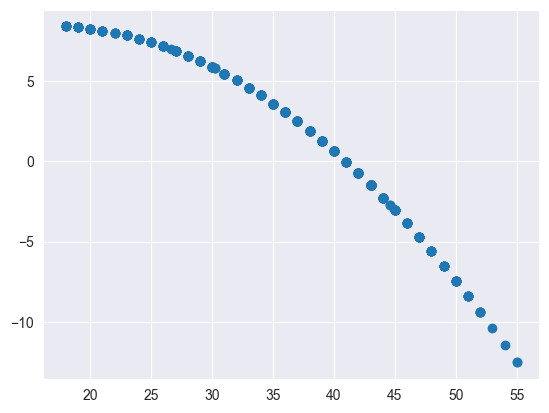

In [235]:
plt.scatter(y=design_train[:,groups_train == 2] @ soln_MLE[groups_train == 2],
            x=x_train_nl['temp'])

In [236]:
x_train_nl.columns

Index(['distance', 'temp', 'dewp', 'humid', 'pressure', 'sched_dep_hour',
       'sched_arr_hour'],
      dtype='object')

In [237]:
x_train_nl['temp']

6276    37.0
7174    40.0
1303    37.0
6571    35.0
5989    42.0
        ... 
5865    38.0
5921    33.0
6104    37.0
909     31.0
8330    19.0
Name: temp, Length: 735, dtype: float64

In [353]:
import numpy as np
import matplotlib.pyplot as plt
import math

def plot_main_effects(design_train, x_train_nl, soln, groups, names_dict,
                      ylim_l, ylim_u, nfigs=3):
    # list of your covariate names
    colnames = list(x_train_nl.columns)
    # filter to only those variables with a non-zero fitted effect
    eligible = [
        var for var in colnames
        if np.abs(soln[groups == (colnames.index(var) + 1)]).sum() != 0
    ]
    
    P = len(eligible)
    if P == 0:
        print("No main effects to plot.")
        return
    
    # layout: nfigs columns, enough rows to fit all P plots
    ncols = nfigs
    nrows = math.ceil(P / ncols)
    
    fig, axes = plt.subplots(nrows, ncols,
                             figsize=(4 * ncols, 4 * nrows),
                             squeeze=False)
    axes_flat = axes.flatten()
    
    for idx, var_name in enumerate(eligible):
        ax = axes_flat[idx]
        group_idx = colnames.index(var_name) + 1
        
        # compute fitted additive effect for this group
        y_vals = design_train[:, groups == group_idx] @ soln[groups == group_idx]
        x_vals = x_train_nl[var_name]
        
        ax.scatter(x_vals, y_vals)
        ax.set_xlabel(names_dict[var_name], fontsize=13)
        ax.set_ylabel("Fitted additive effect (minutes)", fontsize=13)
        ax.set_ylim(ylim_l, ylim_u)
    
    # turn off any unused subplots
    for ax in axes_flat[P:]:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()


def plot_main_effects(design_train, x_train_nl, soln, soln_MLE,
                      groups, names_dict,
                      ylim_l, ylim_u):
    my_palette = {"Proposed": "#48c072",
                  "Naive": "#fc5a50",
                  "Data Splitting": "#03719c"}
    
    # list of your covariate names
    colnames = list(x_train_nl.columns)
    # filter to only those variables with a non-zero fitted effect
    eligible_naive = [
        var for var in colnames
        if np.abs(soln[groups == (colnames.index(var) + 1)]).sum() != 0
    ]
    eligible_MLE = [
        var for var in colnames
        if np.abs(soln_MLE[groups == (colnames.index(var) + 1)]).sum() != 0
    ]
    eligible_union = list(set(eligible_MLE) | set(eligible_naive))
    
    P = len(eligible_union)
    if P == 0:
        print("No main effects to plot.")
        return
    
    # layout: nfigs columns, enough rows to fit all P plots
    ncols = len(eligible_union)
    nrows = math.ceil(P / ncols)
    
    fig, axes = plt.subplots(nrows, ncols,
                             figsize=(4 * ncols, 4 * nrows),
                             squeeze=False)
    axes_flat = axes.flatten()
    
    for idx, var_name in enumerate(eligible_union):
        ax = axes_flat[idx]
        group_idx = colnames.index(var_name) + 1
        
        if var_name in eligible_naive:
            # compute fitted additive effect for this group
            y_vals = design_train[:, groups == group_idx] @ soln[groups == group_idx]
            x_vals = x_train_nl[var_name]
            
            ax.scatter(x_vals, y_vals, label="Naive", color=my_palette["Naive"])
            ax.set_xlabel(names_dict[var_name], fontsize=15)
            ax.set_ylabel("Fitted additive effect (minutes)", fontsize=15)
            ax.set_ylim(ylim_l, ylim_u)
        if var_name in eligible_MLE:
            # compute fitted additive effect for this group
            y_vals = design_train[:, groups == group_idx] @ soln_MLE[groups == group_idx]
            x_vals = x_train_nl[var_name]
            
            ax.scatter(x_vals, y_vals, label="Proposed", color=my_palette["Proposed"])
            ax.set_xlabel(names_dict[var_name], fontsize=15)
            ax.set_ylabel("Fitted additive effect (minutes)", fontsize=15)
            ax.set_ylim(ylim_l, ylim_u)
        if idx == 1:
            # add legend
            ax.legend(title="Legend", loc="lower center")
            
    # Now, create a single global legend.
    # We'll extract the handles and labels from one of the axes (since both share the same palette & labels).
    handles, labels = axes_flat[1].get_legend_handles_labels()
    # Remove the legend from the first subplot (so it doesn't appear there)
    axes_flat[1].legend_.remove()

    # Place the legend above the subplots, centered horizontally.
    fig.legend(handles, labels, loc='lower center', ncol=len(labels),
               title="Method", bbox_to_anchor=(0.5, -0.2), fontsize=15, title_fontsize=15)
    
    # turn off any unused subplots
    for ax in axes_flat[P:]:
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

In [354]:
names_dict = {"temp": r"Temperature ($^\circ$F)",
              "pressure": "Sea level pressure (millibars)",
              "sched_dep_hour": "Scheduled departure hour",
              "sched_arr_hour": "Scheduled arrival hour"}

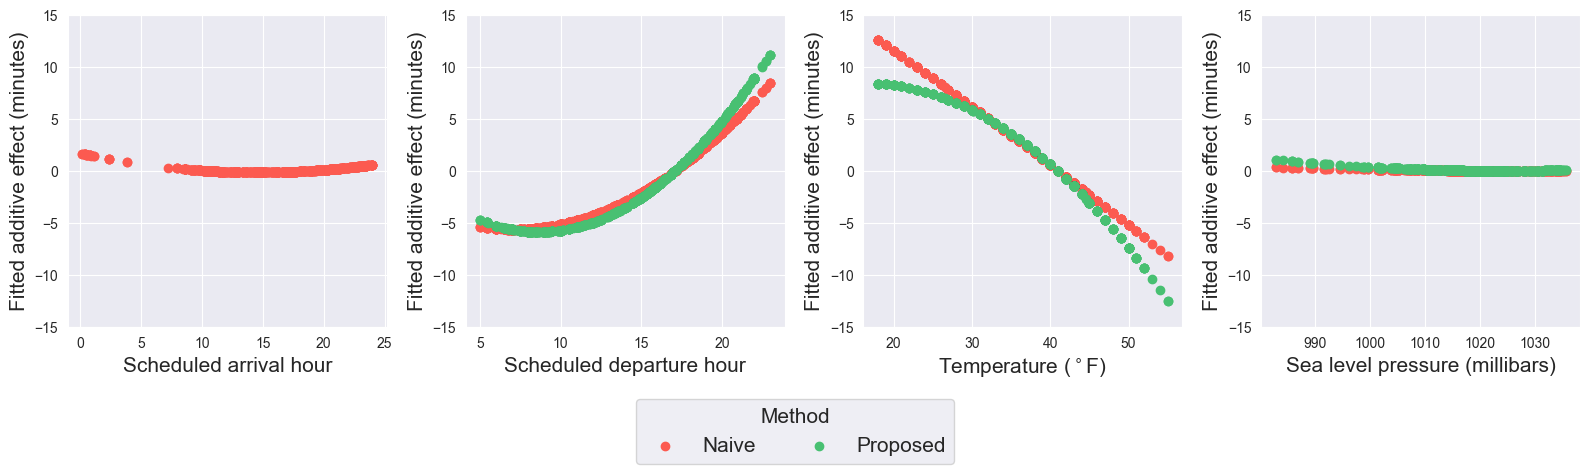

In [355]:
plot_main_effects(design_train=design_train,
                  x_train_nl=x_train_nl,
                  soln=soln,
                  soln_MLE=soln_MLE,
                  groups=groups_train,
                  names_dict=names_dict, 
                  ylim_l=-15, ylim_u=15)

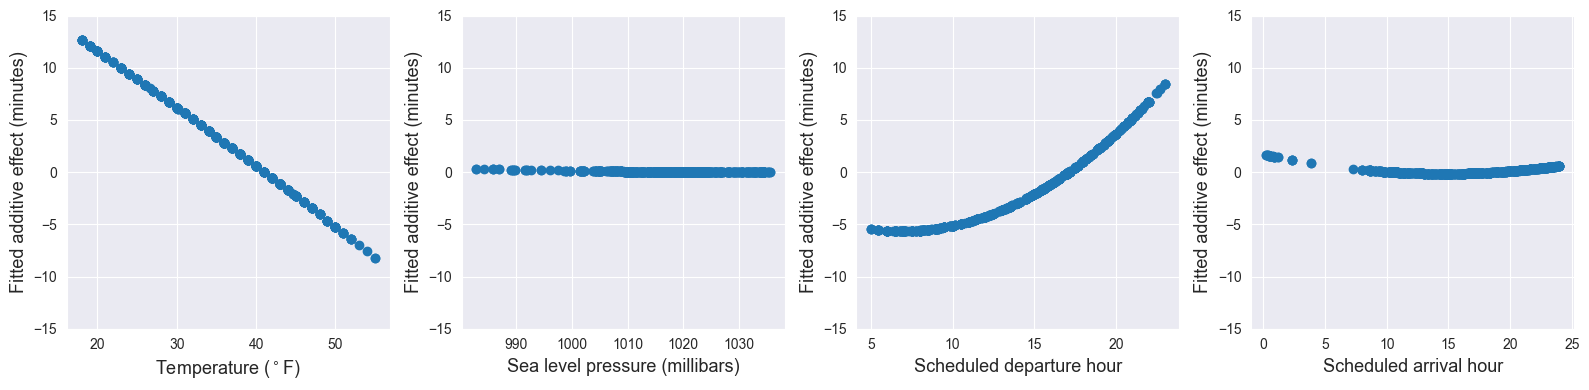

In [288]:
plot_main_effects(design_train=design_train,
                  x_train_nl=x_train_nl,
                  soln=soln,
                  groups=groups_train,
                  names_dict=names_dict, 
                  ylim_l=-15, ylim_u=15, nfigs=4)

In [241]:
x_train_nl.columns

Index(['distance', 'temp', 'dewp', 'humid', 'pressure', 'sched_dep_hour',
       'sched_arr_hour'],
      dtype='object')

In [242]:
x_train_l

,plane_age,seats,wind_dir,wind_speed,precip,visib
6276,-0.010725,0.066434,0.012624,-0.000856,0.062942,0.018374
7174,-0.037106,0.012914,0.012624,-0.022561,-0.012629,0.018374
1303,-0.010725,0.066434,-0.046299,-0.044266,-0.013392,0.018374
6571,0.052589,0.005415,0.043636,-0.000856,-0.012629,0.018374
5989,-0.058210,-0.032765,0.006422,-0.000856,-0.013392,0.018374
...,...,...,...,...,...,...
5865,0.020932,-0.035492,-0.040096,-0.037031,-0.013392,0.018374
5921,0.026209,-0.055945,0.015725,-0.008091,-0.013392,0.018374
6104,-0.016001,-0.030378,0.046737,0.006378,0.062942,-0.048999
909,-0.016001,0.066434,-0.049400,0.006378,-0.012629,-0.008575


In [243]:
naive_train

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 True]

In [244]:
pd.DataFrame(result_naive)[pd.DataFrame(result_naive)['pval'] < 0.1]

,i,j,CI_l,CI_u,beta_hat,pval
11,1,6,-0.004813,-0.000700,-0.002756,0.027287
12,1,7,-0.119630,-0.024062,-0.071846,0.013275
16,1,11,-0.096608,-0.006443,-0.051526,0.059787
23,2,12,0.001351,0.017346,0.009349,0.054195
36,4,11,-0.128926,-0.020201,-0.074563,0.023886
50,6,12,-0.004974,0.000002,-0.002486,0.099853
53,7,12,-0.287614,-0.007033,-0.147323,0.083714
58,9,10,0.010666,0.404281,0.207473,0.082525
59,9,12,-0.232027,-0.040315,-0.136171,0.019303
62,11,12,-1.757318,-0.544371,-1.150845,0.001776


In [245]:
pd.DataFrame(result_MLE)[pd.DataFrame(result_MLE)['pval'] < 0.1]

,i,j,CI_l,CI_u,beta_hat,pval
7,1,2,0.007807,0.023873,0.015840,0.001182
11,1,6,-0.020166,-0.005309,-0.012738,0.004795
12,1,7,-0.259521,-0.035893,-0.147707,0.029791
22,2,10,0.002295,0.033528,0.017911,0.059217
31,4,6,-0.011866,-0.003237,-0.007552,0.003987
36,4,11,-0.284397,-0.000538,-0.142467,0.098721
38,5,6,-0.004950,-0.001493,-0.003221,0.002177
45,6,7,-0.030070,-0.008752,-0.019411,0.002741
46,6,8,-31.842092,-0.603693,-16.222893,0.087557
47,6,10,-0.036473,-0.007934,-0.022204,0.010484


In [246]:
naive_test_df[naive_test_df['pval'] < 0.1]

,i,j,CI_l,CI_u,beta_hat,pval
3,0,6,-0.000010,-5.272651e-07,-0.000005,6.844454e-02
11,1,6,-0.001301,-3.840700e-04,-0.000843,2.504408e-03
13,1,8,1.097380,3.382331e+01,17.460347,7.918895e-02
18,2,4,0.000055,1.358080e-03,0.000706,7.463095e-02
20,2,6,-0.000115,-2.643669e-05,-0.000071,8.558206e-03
22,2,10,0.002780,9.054424e-03,0.005917,1.916019e-03
23,2,12,0.001937,5.378056e-03,0.003658,4.701130e-04
24,3,4,-0.015622,-3.232902e-03,-0.009428,1.229323e-02
25,3,5,-0.006120,-1.533527e-03,-0.003827,6.047622e-03
26,3,6,-0.000715,-1.841448e-04,-0.000449,5.318028e-03


In [247]:
MLE_test_df[MLE_test_df['pval'] < 0.1]

,i,j,CI_l,CI_u,beta_hat,pval
11,1,6,-0.002155,-0.000863,-0.001509,1.227282e-04
13,1,8,2.557210,36.032126,19.294668,5.790372e-02
18,2,4,0.000058,0.001360,0.000709,7.323094e-02
22,2,10,0.002771,0.009042,0.005906,1.944510e-03
24,3,4,-0.015406,-0.003054,-0.009230,1.394893e-02
25,3,5,-0.006046,-0.001471,-0.003758,6.869840e-03
26,3,7,0.088457,0.137445,0.112951,3.295551e-14
27,3,8,0.429187,12.631918,6.530553,7.827159e-02
28,3,10,0.278133,0.388702,0.333418,3.361002e-23
30,4,5,-0.004222,-0.000888,-0.002555,1.167346e-02


In [264]:
p_nl = 7
nonzero_MLE[1:p_nl+1]

array([False, False,  True,  True, False, False, False])

In [266]:
selected_groups_MLE

[0, 2, 5, 6, 8, 9, 11, 13]

In [267]:
nonzero_MLE

array([ True, False, False,  True,  True, False, False, False, False,
        True,  True,  True,  True, False, False,  True,  True, False,
        True, False,  True])

{'i': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  2,
  2,
  2,
  2,
  2,
  2,
  3,
  3,
  3,
  3,
  3,
  3,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  4,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  6,
  6,
  6,
  6,
  7,
  7,
  7,
  7,
  7,
  8,
  8,
  8,
  8,
  9,
  9,
  10,
  10,
  11],
 'j': [1,
  4,
  5,
  7,
  8,
  10,
  12,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  4,
  5,
  7,
  8,
  10,
  12,
  4,
  5,
  7,
  8,
  10,
  12,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  7,
  8,
  10,
  12,
  8,
  9,
  10,
  11,
  12,
  9,
  10,
  11,
  12,
  10,
  12,
  11,
  12,
  12],
 'CI_l': [-9.538124820180962e-05,
  -2.0818208014069765e-05,
  -2.7038121816951682e-05,
  -7.54803779906555e-05,
  -0.011499594313444939,
  -3.0278133940858442e-05,
  -3.983570101449003e-05,
  -0.0010942101719311748,
  -0.024120064598719567,
  -0.013918531286614652,
  -0.006353754985494436,
  -0.0021550969422887392,
  -0.0398

In [295]:
f1_score(naive_test, naive_train)

0.19047619047619047

In [296]:
precision_score(naive_test, naive_train)

0.4

In [297]:
recall_score(naive_test, naive_train)

0.125

In [299]:
f1_score(MLE_test, MLE_train)

0.41025641025641024

In [300]:
precision_score(MLE_test, MLE_train)

0.6153846153846154

In [301]:
recall_score(MLE_test, MLE_train)

0.3076923076923077